In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model,save_model
import tensorflow as tf
from numpy import array
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.utils import np_utils
Encoder = LabelEncoder()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv("tweets_cleaned.csv")

In [3]:
data

,id,class,text,text_cleaned
0,1.362219e+18,entertainment,RT @thefirstindia: Fans of #ShahRukhKhan are e...,fans shahrukhkhan eagerly waiting get glimpse ...
1,1.370396e+18,technology,RT @BambooSystems: Building #cloud #datacenter...,building cloud datacenters internet speed
2,1.373234e+18,technology,RT @newsycombinator: Tesla's “Full Self Drivin...,teslas full self driving beta laughably bad po...
3,1.371423e+18,education,👧Visit my new website featuring only my kids b...,visit new website featuring kids books laugh f...
4,1.371426e+18,education,**NEW POST** AD GIFTED | Book Review: The Libr...,new post ad gifted book review library dead bo...
...,...,...,...,...
19564,1.372622e+18,politics,It takes a killer to know a killer - Putin bla...,takes killer know killer putin blasts biden pu...
19565,1.370659e+18,education,Cats sleep 16 to 18 hours per day. #facts #fun...,cats sleep hours per day facts funfacts love s...
19566,1.373243e+18,education,🕵🏽 March #STEM Mystery of the Month: Soil Solu...,march stem mystery month soil solution lesson ...
19567,1.372768e+18,entertainment,Today ott release movies:- \n\n#sangathalaivan...,today ott release movies sangathalaivan falcon...


In [4]:
data.text_cleaned.apply(lambda x: len(x.split(" "))).max()

24

In [5]:
text = data['text_cleaned'].tolist()
y = data['class']

In [6]:
y = Encoder.fit_transform(y)
y = np_utils.to_categorical(y,5)

In [7]:
y

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [8]:
token = Tokenizer()
token.fit_on_texts(text)

In [9]:
vocab_size  = len(token.word_index) + 1

In [10]:
encoded_text = token.texts_to_sequences(text)

In [11]:
max_length = 30
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [12]:
glove_vectors = dict()

In [13]:
file = open('glove.twitter.27B.200d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]
    #storing the word in the variable
    vectors = np.asarray(values[1: ])
    #storing the vector representation of the respective word in the dictionary
    glove_vectors[word] = vectors
file.close()

In [14]:
keys = glove_vectors.keys()

In [15]:
word_vector_matrix = np.zeros((vocab_size, 200))
for word, index in token.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

In [17]:
model =  tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 200, input_length=max_length, weights = [word_vector_matrix], trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5)
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 200)           5309200   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3

In [19]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
             optimizer=tf.keras.optimizers.Adam(1e-4), 
             metrics=['accuracy'])

In [20]:
history = model.fit(x = X_train, y = y_train, epochs = 25, validation_data = (X_test, y_test))

model.save('malenoma.h5')

model.save_weights('malenoma_weights.h5')

Epoch 1/25
429/429 [==============================] - 33s 43ms/step - loss: 1.4539 - accuracy: 0.3662 - val_loss: 0.7882 - val_accuracy: 0.7307
Epoch 2/25
429/429 [==============================] - 11s 25ms/step - loss: 0.8066 - accuracy: 0.7232 - val_loss: 0.6680 - val_accuracy: 0.7699
Epoch 3/25
429/429 [==============================] - 13s 30ms/step - loss: 0.6865 - accuracy: 0.7757 - val_loss: 0.6149 - val_accuracy: 0.7895
Epoch 4/25
429/429 [==============================] - 13s 30ms/step - loss: 0.6445 - accuracy: 0.7904 - val_loss: 0.6065 - val_accuracy: 0.7866
Epoch 5/25
429/429 [==============================] - 14s 32ms/step - loss: 0.5898 - accuracy: 0.8074 - val_loss: 0.5888 - val_accuracy: 0.7985
Epoch 6/25
429/429 [==============================] - 13s 31ms/step - loss: 0.5631 - accuracy: 0.8162 - val_loss: 0.5853 - val_accuracy: 0.8022
Epoch 7/25
429/429 [==============================] - 14s 32ms/step - loss: 0.5399 - accuracy: 0.8245 - val_loss: 0.5785 - val_accuracy:

In [21]:
y = model.evaluate(x = X_test, y = y_test)
y[1]

184/184 [==============================] - 2s 9ms/step - loss: 0.6850 - accuracy: 0.8201


0.820132851600647

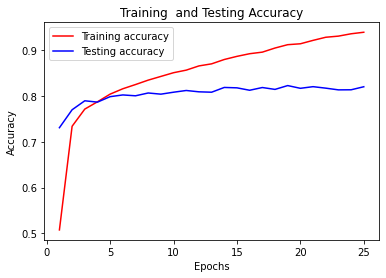

<Figure size 432x288 with 0 Axes>

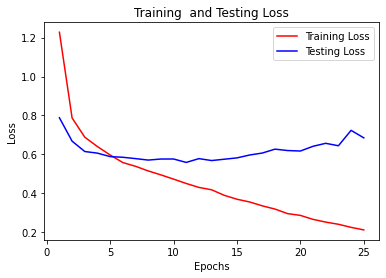

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epochs = range(1,len(train_acc)+1)
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, test_acc, 'b', label='Testing accuracy')
plt.title('Training  and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, test_loss, 'b', label='Testing Loss')
plt.title('Training  and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()